# Load model

In [2]:
import torch.nn as nn
import torch

class VGG(nn.Module):
    def __init__(self, features, DROPOUT=0.5, NUM_CLASSES=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(DROPOUT),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(DROPOUT),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(DROPOUT),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Dropout(DROPOUT),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(DROPOUT),
            nn.Linear(512, NUM_CLASSES),
            nn.Softmax(dim=1)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNom2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg_model = VGG(make_layers(cfg), DROPOUT=0.5, NUM_CLASSES=2, init_weights=False)

checkpoint = torch.load('/kaggle/input/celeb-a/best_checkpoint.pt')
vgg_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [3]:
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Test set evaluate

In [4]:
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from torchvision.transforms import transforms
from torchvision.transforms import InterpolationMode


In [5]:
folder='/kaggle/input/test-set/Test'

In [29]:
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.metrics import precision_score, recall_score, confusion_matrix

thresholds = torch.arange(0.1, 1.0, 0.1)

best_f1_score = 0 
vgg_model.to('cuda')

for threshold in thresholds:
    predictions = []
    labels = []

    for root, dirs, files in os.walk(folder):
        if files:
            for filename in files:
                if 'Female' in filename:
                    labels.append('Female')
                elif 'Male' in filename:
                    labels.append('Male')
                    
                image_path = os.path.join(root, filename)
                image = Image.open(image_path).convert('RGB')
                
                transform = transforms.Compose([
                    transforms.Resize(size=(244, 244), interpolation=transforms.InterpolationMode.BICUBIC),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
                image = transform(image)
                image = image.unsqueeze(0).to('cuda')  # Di chuyển dữ liệu lên GPU
                
                with torch.no_grad():
                    output = vgg_model(image)
                    prediction = F.softmax(output, dim=1).cpu().numpy()[0][1]  
                
                label = 1 if prediction > threshold else 0
                if label == 0:
                    predictions.append('Female')
                else:
                    predictions.append('Male')
                    
    conf_matrix = confusion_matrix(labels, predictions)
    macro_average_recall = recall_score(labels, predictions, average='macro', zero_division=1)
    macro_average_precision = precision_score(labels, predictions, average='macro', zero_division=1)
    macro_average_f1_score = 2 * (macro_average_precision * macro_average_recall) / (macro_average_precision + macro_average_recall)
    print(f'Threshold: {round(threshold.item(),1)} Precision: {macro_average_precision} Recall: {macro_average_recall} F1-Score: {macro_average_f1_score}')
    
    if best_f1_score < macro_average_f1_score:
        best_cfs_matrix = conf_matrix
        best_f1_score = macro_average_f1_score
        best_predictions=predictions
    elif best_f1_score >= macro_average_f1_score:
        continue

Threshold: 0.1 Precision: 0.7083703484354951 Recall: 0.5 F1-Score: 0.5862195719653651
Threshold: 0.2 Precision: 0.7083703484354951 Recall: 0.5 F1-Score: 0.5862195719653651
Threshold: 0.3 Precision: 0.8580896401124763 Recall: 0.8657519994349802 F1-Score: 0.8619037904396408
Threshold: 0.4 Precision: 0.8761679579741102 Recall: 0.8865219487507474 F1-Score: 0.8813145438375902
Threshold: 0.5 Precision: 0.884252260716512 Recall: 0.8923297559167346 F1-Score: 0.8882726455480883
Threshold: 0.6 Precision: 0.8904017016479546 Recall: 0.8935691638997558 F1-Score: 0.8919826208397282
Threshold: 0.7 Precision: 0.8948350914908281 Recall: 0.8820542197752282 F1-Score: 0.8883986902820142
Threshold: 0.8 Precision: 0.7916296515645049 Recall: 0.5 F1-Score: 0.6128921325130869
Threshold: 0.9 Precision: 0.7916296515645049 Recall: 0.5 F1-Score: 0.6128921325130869


Confusion Matrix:
[[5309  600]
 [ 470 3752]]


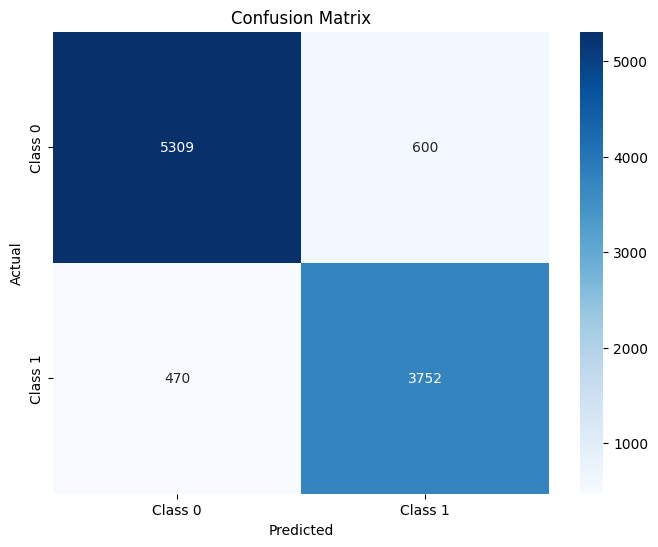

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Confusion Matrix:")
print(best_cfs_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(best_cfs_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
binary_labels=[]
for i in labels:
    if i=='Female':
        binary_labels.append(0)
    else:
        binary_labels.append(1)

In [34]:
binary_predictions=[]
for i in best_predictions:
    if i=='Female':
        binary_predictions.append(0)
    else:
        binary_predictions.append(1)

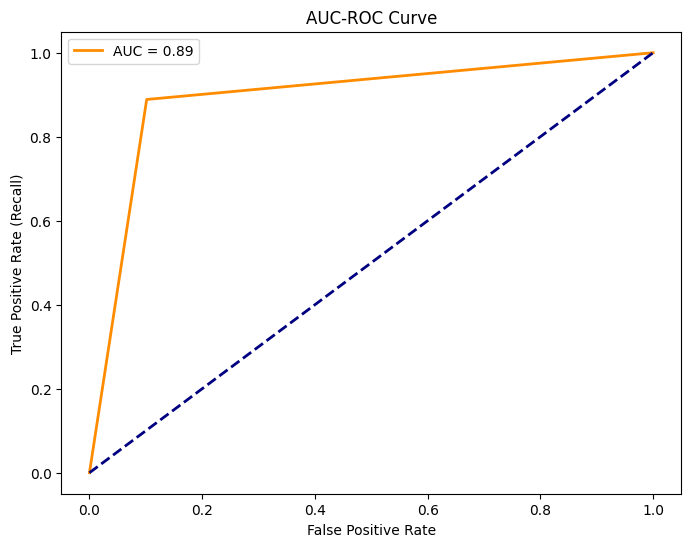

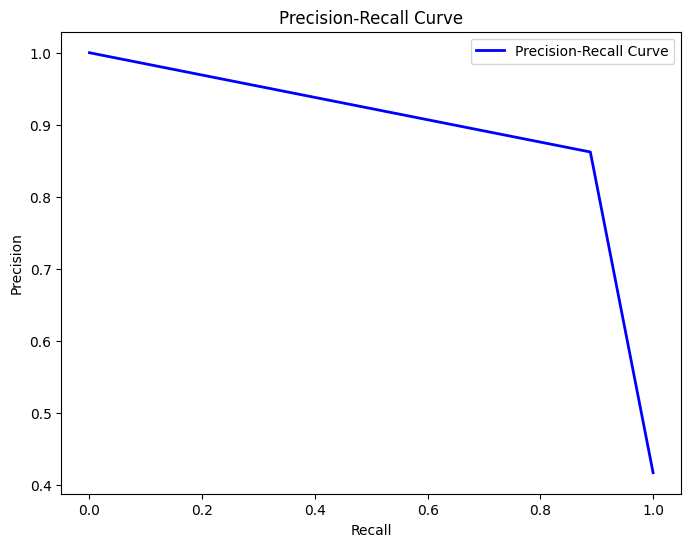

In [35]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, _ = roc_curve(binary_labels, binary_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('AUC-ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(binary_labels, binary_predictions)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()